In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt

In [3]:
#creem una data limit, en aquest cas 1900 i la tornem un datetime per poder comparar amb la taula
datestringMin = "1990-01-01"
datestringMax = "2013-01-01"
dtMin = datetime.strptime(datestringMin, '%Y-%m-%d')
dtMax = datetime.strptime(datestringMax, '%Y-%m-%d')

#carreguem csv
#creem un DF en pandas, ficant na_values es canvia el tipus de les temperatures a float enlloc de object( degut als NaN es fica a object)
emisions = pd.read_csv("Datasets/GreenhouseEmitions/greenhouse_gas_inventory_data_data.csv", na_values = ['no info', '.'])
temperatures=pd.read_csv("Datasets/TemperaturaGlobal/GlobalLandTemperaturesByCountry.csv", na_values = ['no info', '.'])


#es descarta Chipre perque no existeix al dataset
paisos = ["Austria", "Belgium", "Bulgaria", "Croatia", "Czech Republic", "Denmark",
          "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Ireland", "Italy", "Latvia",
          "Lithuania", "Luxembourg", "Malta", "Netherlands", "Poland", "Portugal", "Romania", "Slovakia",
          "Slovenia", "Spain", "Sweden","United Kingdom"]
tipusGas = [
  "carbon_dioxide_co2_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent",
  "nitrous_oxide_n2o_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent",
  "methane_ch4_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent"
]
paisosTest = ["Austria"]
tempPais={}
emisionsPais={}

In [4]:
for pais in paisos:
    arrayGasos=[]
    gasxMes = {"CO2":[],"N2O":[],"CH4":[]}
    for tipus in tipusGas:
        emisionsGas = emisions[(emisions['category'] == tipus) & (emisions["country_or_area"] == pais) & (emisions['year'] < 2013)]
        emisionsGas = emisionsGas[['year','value']]
        emisionsGas = emisionsGas.sort_values(by = ['year'])
        punts = []
        #iterar sobre cada fila del dataframe guardant dins d'una llista de tuples que seran punts per interpolar, arrodonint els kt de Co2 a 3 decimals
        for index,row in emisionsGas.iterrows():
            punts.append((row['year'], round(row['value'],3)))
        xi, yi = zip(*punts)
        #numero de punts que em de treure amb la interpolacio
        x = np.linspace(min(xi), max(xi), num=len(punts)*12)
        ysp = InterpolatedUnivariateSpline(xi, yi)(x)

        #per cada valor del array resultant d'interpolar ho relacionem amb un mes any.mes
        anyInicial = 1990
        mesInicial = 0.00
        for mostra in ysp:
            if (mesInicial > 0.11):
                anyInicial+= 1
                mesInicial = 0.01
            else:
                mesInicial+= 0.01
            if (tipus == "carbon_dioxide_co2_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent"):
                gasxMes["CO2"].append((anyInicial+mesInicial,pais,mostra))
            elif(tipus == "nitrous_oxide_n2o_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent"):
                gasxMes["N2O"].append((anyInicial+mesInicial,pais,mostra))
            elif(tipus == "methane_ch4_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent"):
                gasxMes["CH4"].append((anyInicial+mesInicial,pais,mostra))
        if (tipus == "carbon_dioxide_co2_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent"):
            labels = ['dt','Country','CO2']
            emisionsGas=pd.DataFrame.from_records(gasxMes['CO2'], columns=labels)
        elif(tipus == "nitrous_oxide_n2o_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent"):
            labels = ['dt1','Country1','N2O']
            emisionsGas=pd.DataFrame.from_records(gasxMes['N2O'], columns=labels)    
        elif(tipus == "methane_ch4_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent"):
            labels = ['dt2','Country2','CH4']      
            emisionsGas=pd.DataFrame.from_records(gasxMes['CH4'], columns=labels)
        arrayGasos.append(emisionsGas)

    emisionsTotals=pd.concat(arrayGasos, axis=1, sort=False)
    emisionsTotals=emisionsTotals.drop(['dt2','Country2','dt1','Country1'], axis=1)
    emisionsPais[pais]=emisionsTotals
    arrayGasos=[]

In [5]:
for pais in paisos:
  #fa una copia del DF original amb les columnes que s'indiquen
  temperaturesPais = temperatures[['Country','AverageTemperature','dt']]
  #convertim les dates a datetime per poder agafar les que ens interessin
  temperaturesPais[['dt']] = temperaturesPais[['dt']].apply(pd.to_datetime)
  #ens centrem en un pais en concret en anys més elevats que 1900
  temperaturesPais = temperaturesPais[(temperaturesPais['dt'] >= dtMin) & (temperaturesPais['Country'] == pais) & (temperaturesPais['dt'] < dtMax)]
  #Fent aixo no sabem si esta copiant o substituint
  #dfGer['dt'].dt.strftime('%Y')
  #amb el loc si que sabem que substitueix a part de fer menys accessos a les dades
  temperaturesPais.loc[:,'dt'] = temperaturesPais.loc[:,'dt'].dt.strftime('%Y')
  
  #convertim les dates de string a float
  temperaturesPais['dt'] = temperaturesPais.dt.astype('float')
  #fiquem el mes com si fossin decimals
  anyInicial = 1990
  mesInicial = 0.00
  for index, row in temperaturesPais.iterrows():
    if (mesInicial > 0.11):
      mesInicial = 0.01
    else:
      mesInicial+= 0.01
    temperaturesPais.loc[index,'dt'] = float(row['dt'])
    temperaturesPais.loc[index,'dt'] = row['dt']+mesInicial
  tempPais[pais] = temperaturesPais
  print (pais)

C:\Users\Miquel\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Austria
Belgium
Bulgaria
Croatia
Czech Republic
Denmark
Estonia
Finland
France
Germany
Greece
Hungary
Ireland
Italy
Latvia
Lithuania
Luxembourg
Malta
Netherlands
Poland
Portugal
Romania
Slovakia
Slovenia
Spain
Sweden
United Kingdom


In [6]:
#fem merge dels datasets de temperatures i el de emisions
result = pd.merge(emisionsPais["Germany"], tempPais["Germany"], on=['dt','Country'])
dadesEuropa=[]
for pais in emisionsPais:
  dadesEuropa.append(pd.merge(emisionsPais[pais], tempPais[pais], on=['dt','Country']))
result=pd.concat(dadesEuropa, ignore_index=True)
resultPlot=pd.concat(dadesEuropa, ignore_index=True)
mes = 1
cops = 1
for index in range(0,len(result)):
    result.at[index,'Mes'] = mes
    if (mes==12):
        mes=1
    else:
        mes =mes+1
    
result.rename(columns={'dt':'Data'},inplace=True)
resultPlot.rename(columns={'dt':'Data'},inplace=True)
result['Data'] = result.Data.astype('int')
result['Mes'] = result.Mes.astype('int')
print(result.isnull().any())
#result.to_csv('DataSetFinal.csv')

Data                  False
Country               False
CO2                   False
N2O                   False
CH4                   False
AverageTemperature    False
Mes                   False
dtype: bool


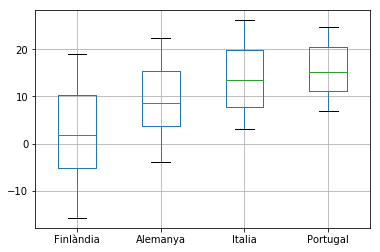

In [22]:
resultFin = result[(result['Country'] == "Finland")]
resultFin = resultFin['AverageTemperature']
resultIt = result[(result['Country'] == "Italy")]
resultIt = resultIt['AverageTemperature']
resultGer = result[(result['Country'] == "Germany")]
resultGer = resultGer['AverageTemperature']
resultPor = result[(result['Country'] == "Portugal")]
resultPor = resultPor['AverageTemperature']

boxDF=pd.DataFrame({'Finlàndia':resultFin,'Alemanya':resultGer,'Italia':resultIt,'Portugal':resultPor})
boxplot = boxDF.boxplot(column=['Finlàndia', 'Alemanya', 'Italia','Portugal'])

In [ ]:
print (resultPlot2)